# Synchornization in complete networks of neurons
Here is the dynamics of neurons potentails in rotational model :
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) -g  E \\
\ddot{E}+ 2\alpha \dot{E}+\alpha^{2}E =\frac{\alpha^{2}}{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
num_neurons = 10000
g = 50
random_input_span = (8.5,13.5) #it should fall in the well defined cos(\theta) domain.

total_time = 1000
time_step = 0.01
total_steps = int(total_time/time_step)
time_span = np.arange(0,total_time,time_step)

delay_time = 0.1
delay_step = int(delay_time/time_step)

alpha = 20
m_arr = np.zeros(total_steps)
e_arr = np.zeros(total_steps)

theta_arr = np.zeros(num_neurons,dtype = float)
# theta_arr = np.random.uniform(0,2*np.pi,size = num_neurons)
random_input = np.random.uniform(*random_input_span,size = num_neurons)

In [3]:
saving_path_name = 'single_runs'
current_version = 'N{}_T{}_g{}_input_{}_{}'.format(num_neurons,total_time,g,random_input_span[0],random_input_span[1])
try:
    saving_path = os.path.join(saving_path_name, current_version) 
    os.makedirs(saving_path)
except:
    pass

In [4]:
spiking_records = np.array( np.zeros((total_steps,num_neurons)), dtype = bool )
amin_saman_param = np.zeros( total_steps )

## Instrumentes to capture spiking frequency
Here we use *cornometer* and number of spikies to measure their frequencies.

In [5]:
spiking_cornometer = np.zeros(num_neurons)
total_spikes_intervals = np.zeros(num_neurons)
total_spikes_num = np.zeros(num_neurons)

In [6]:
def retarded_spikes_record(step):
    """
    This is the function which take cares of response delay between spikes and their effects.
    """
    if step > delay_step: 
        return np.sum(spiking_records[step - delay_step])
    else:
        return 0


## "For" loop on the march!
To make equations more solvable we turn them into three cases of linear first order equations:
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) - g E \\
\dot{E} = M - \alpha E\\
\dot{M} = -  \alpha M + \frac{ \alpha^{2} }{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [7]:
for i in tqdm( range(total_steps - 1) ):
    theta_arr = theta_arr + (random_input - np.cos(theta_arr) - g * e_arr[i] )*time_step
    
    #here we should spot the spiking neurons.
    spiking_records[i] = theta_arr > np.pi
    theta_arr = theta_arr - 2 * np.pi * spiking_records[i]
#     theta_arr = theta_arr + 2 * np.pi * (theta_arr < - np.pi)
    #neurons activity
    m_arr[i+1] = m_arr[i] + time_step*( -alpha*m_arr[i] ) + ( (alpha**2)/num_neurons ) *retarded_spikes_record(i) 
    e_arr[i+1] = e_arr[i] + time_step*( m_arr[i] - alpha*e_arr[i] )
    #
    left_handed_neurons = np.cos(theta_arr) < 0
    amin_saman_param[i] = np.mean( np.sin(theta_arr[left_handed_neurons]) )**2
    #frequency calculator
    total_spikes_num = total_spikes_num + spiking_records[i]
    total_spikes_intervals = total_spikes_intervals + spiking_cornometer * spiking_records[i] #add to spike lapsed time
    spiking_cornometer = spiking_cornometer * (spiking_records[i]-1)*(-1) #reset the spikied cornos
    spiking_cornometer = spiking_cornometer + (spiking_records[i]-1)*(-1) #update the not spikied ones
    
    

  0%|                                                                                        | 0/99999 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████████████████████████████████████| 99999/99999 [02:49<00:00, 590.62it/s]


In [8]:
sigma = np.std( e_arr )
sigma

0.2556821428892551

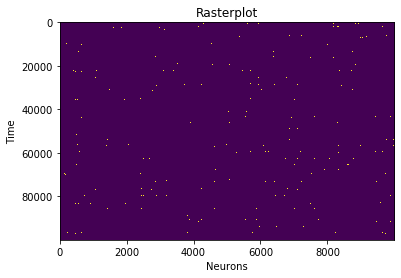

In [9]:
plt.imshow( spiking_records, aspect= 'auto')
plt.xlabel('Neurons')
plt.ylabel('Time')
plt.title('Rasterplot')
plt.savefig( os.path.join(saving_path, 'raster_plot.png'))

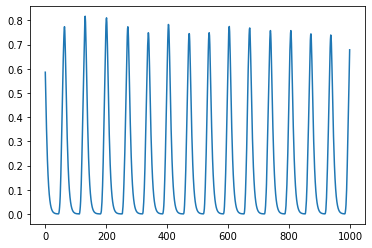

In [10]:
plt.plot(e_arr[-1000:])

In [11]:
random_input - g *e_arr[-1] 

array([-21.18000962, -21.81222635, -21.27660925, ..., -24.61907053,
       -24.56603924, -23.49719398])

(array([ 246.,  253.,  259.,  261.,  256.,  227.,  215.,  169.,  123.,
        7991.]),
 array([-1379.09882164, -1240.92648621, -1102.75415079,  -964.58181536,
         -826.40947994,  -688.23714451,  -550.06480909,  -411.89247366,
         -273.72013824,  -135.54780282,     2.62453261]),
 <a list of 10 Patch objects>)

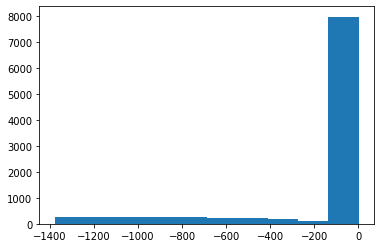

In [12]:
plt.hist(theta_arr )

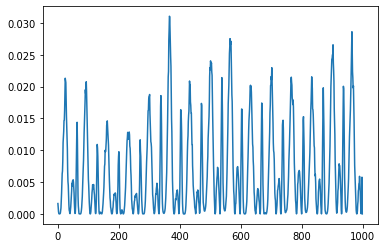

In [13]:
plt.plot(amin_saman_param[-1000:])

In [14]:
np.mean(amin_saman_param[-100:])

0.008485196809109825

## Calculate frequnecy

In [15]:
spikies_period_mean = total_spikes_intervals * time_step / total_spikes_num
spikies_period_mean

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 2.23667416,  2.90769006,  2.31923077, ...,  0.34      ,
        0.33      , 21.55326087])

In [16]:
heights, bins = np.histogram(spikies_period_mean,bins=np.logspace(np.log10(0.1),np.log10(10.0), 20))
# plt.scatter(bins[:-1],heights)
# plt.yscale('log')
# plt.xscale('log')
heights, bins

(array([   0,    0,    0,    0, 1995,  536,    0,    0,    0,    0,    0,
         332, 1491, 1116,  865,  726,  527,  394,  280], dtype=int64),
 array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
         0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
         1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
         3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ]))

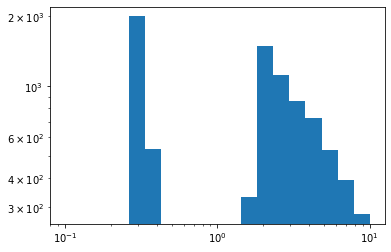

In [17]:
(heights, bins, patches) = plt.hist(spikies_period_mean,bins=np.logspace(np.log10(0.1),np.log10(10.0), 20))
plt.yscale('log')
plt.xscale('log')

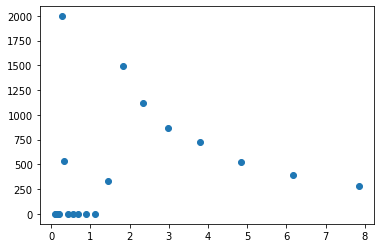

In [18]:
plt.scatter(bins[:-1],heights)
# plt.yscale('log')
# plt.xscale('log')
plt.savefig( os.path.join(saving_path, 'spikies_time_interval.png'))

## Are silent neurons the lower recieved inputs?

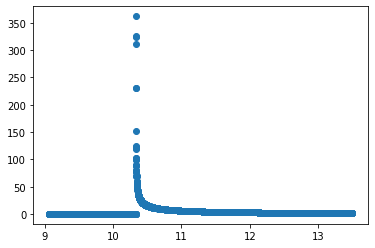

In [19]:
plt.scatter(random_input,spikies_period_mean)

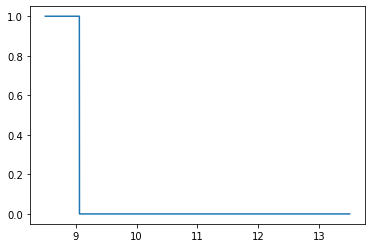

In [20]:
plt.plot(np.sort(random_input), np.isnan( spikies_period_mean[ np.argsort(random_input) ] ) )

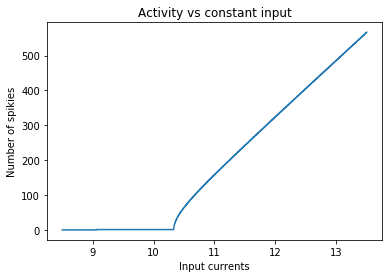

In [21]:
plt.plot(np.sort(random_input), total_spikes_num[ np.argsort(random_input) ] )
plt.xlabel('Input currents')
plt.ylabel('Number of spikies')
plt.title('Activity vs constant input')
plt.savefig(os.path.join(saving_path, 'spikies_num_vs_input.png'))

Text(0.5, 1.0, 'Activity vs constant input')

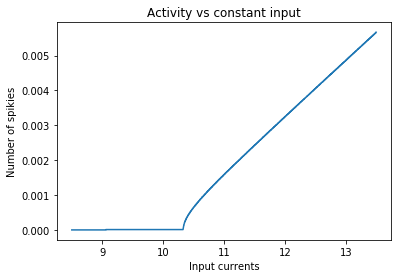

In [27]:
plt.plot(np.sort(random_input), total_spikes_num[ np.argsort(random_input) ]/total_steps )
plt.xlabel('Input currents')
plt.ylabel('Number of spikies')
plt.title('Activity vs constant input')
# plt.savefig(os.path.join(saving_path, 'spikies_num_vs_input.png'))

In [31]:
np.sum( total_spikes_num )*g / (total_steps * (random_input_span[1] - random_input_span[0]) )

198.4138

In [22]:
np.where( total_spikes_num[ np.argsort(random_input) ] > 0)

(array([1109, 1110, 1111, ..., 9997, 9998, 9999], dtype=int64),)

In [23]:
np.sort(random_input)[1053]

9.030626109172044

In [24]:
spikies_period_mean

array([ 2.23667416,  2.90769006,  2.31923077, ...,  0.34      ,
        0.33      , 21.55326087])

In [25]:
np.count_nonzero(~np.isnan(spikies_period_mean))

8891

In [26]:
np.sum(theta_arr >0)

2982